In [ ]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/car_fuel_efficiency.csv')
display(df)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
...,...,...,...,...,...,...,...,...,...,...,...
9699,140,5.0,164.0,2981.107371,17.3,2013,Europe,Diesel,Front-wheel drive,NaN,15.101802
9700,180,NaN,154.0,2439.525729,15.0,2004,USA,Gasoline,All-wheel drive,0.0,17.962326
9701,220,2.0,138.0,2583.471318,15.1,2008,USA,Diesel,All-wheel drive,-1.0,17.186587
9702,230,4.0,177.0,2905.527390,19.4,2011,USA,Diesel,Front-wheel drive,1.0,15.331551


In [3]:
df = df[[
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg',
    ]]

<Axes: >

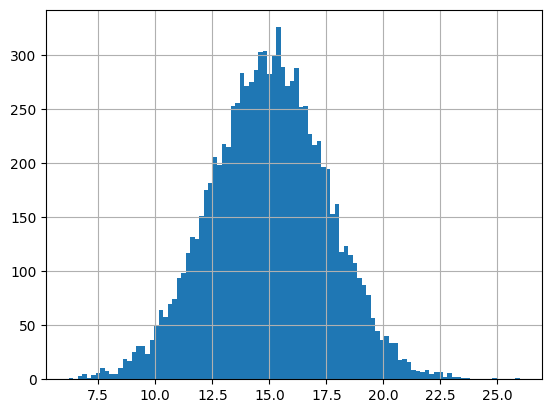

In [4]:
df.fuel_efficiency_mpg.hist(bins=100)

In [5]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [6]:
df.horsepower.median()

np.float64(149.0)

# Validation framework

In [7]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

<Axes: >

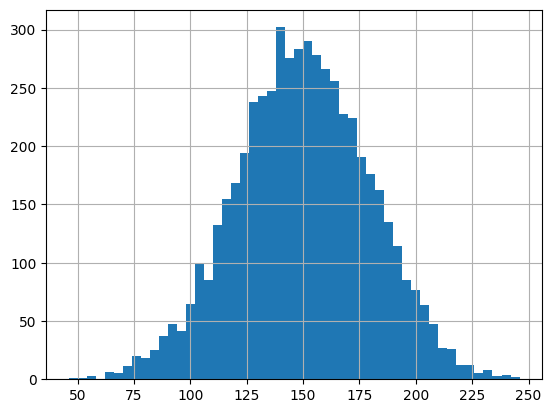

In [8]:
df_train.horsepower.hist(bins=50)

In [9]:
# df_train.loc[df_train.horsepower.isna(), 'horsepower'] = 0

In [10]:
mean_hp = df_train.horsepower.mean()
mean_hp

np.float64(149.54476367006487)

# Linear regression

In [11]:
target = 'fuel_efficiency_mpg'

# y_train_orig = df_train[target].values
# y_val_orig = df_val[target].values
# y_test_orig = df_test[target].values

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

# y_train = np.log1p(df_train[target].values)
# y_val = np.log1p(df_val[target].values)
# y_test = np.log1p(df_test[target].values)

del df_train[target]
del df_val[target]
del df_test[target]

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
df_train.columns.tolist()

['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

In [14]:
def prepare_X(df, fill):
    df = df.fillna(fill)
    X = df.values
    return X

In [15]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [16]:
def train_linear(fill):
    X_train = prepare_X(df_train, fill)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fill)
    y_pred = w_0 + X_val.dot(w)

    return rmse(y_val, y_pred)

In [17]:
for fill in [0, mean_hp]:
    print(f'{fill=} {round(train_linear(fill), 2)}')

fill=0 0.52
fill=np.float64(149.54476367006487) 0.46


In [18]:
for fill in [0, mean_hp]:
    print(f'{fill=} {round(train_linear(fill), 5)}')

fill=0 0.51738
fill=np.float64(149.54476367006487) 0.4636


# Regularised version

In [19]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [20]:
def train_linear_reg(fill, r):
    X_train = prepare_X(df_train, fill)
    w_0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val, fill)
    y_pred = w_0 + X_val.dot(w)

    return rmse(y_val, y_pred)

In [21]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    print(f'r={r}:\t{round(train_linear_reg(0, r), 2)}')

r=0:	0.52
r=0.01:	0.52
r=0.1:	0.52
r=1:	0.52
r=5:	0.52
r=10:	0.52
r=100:	0.52


In [22]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    print(f'r={r}:\t{round(train_linear_reg(0, r), 5)}')

r=0:	0.51738
r=0.01:	0.51711
r=0.1:	0.51875
r=1:	0.52223
r=5:	0.52289
r=10:	0.52298
r=100:	0.52306


# Question 5

In [23]:
res = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]

    fill = 0
    
    print(f'{seed=} {round(train_linear(fill), 5)}')
    res.append(train_linear(fill))

seed=0 0.52065
seed=1 0.52134
seed=2 0.52281
seed=3 0.51595
seed=4 0.51091
seed=5 0.52834
seed=6 0.53139
seed=7 0.50907
seed=8 0.51474
seed=9 0.51319


In [24]:
print(res)

std = np.std(res)
print(std)
round(std, 3)

[np.float64(0.5206531296278794), np.float64(0.5213388912853966), np.float64(0.5228069974667483), np.float64(0.5159516741151383), np.float64(0.5109129460055327), np.float64(0.52834064602523), np.float64(0.5313910658174639), np.float64(0.5090670387377482), np.float64(0.5147399129321204), np.float64(0.5131865908292704)]
0.006989446428843745


np.float64(0.007)

# Question 6

In [25]:
def train_linear_reg_6(fill, r):
    X_train = prepare_X(df_train, fill)
    w_0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val, fill)
    y_pred = w_0 + X_val.dot(w)

    return rmse(y_val, y_pred)

In [26]:
seed = 9

np.random.seed(seed)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

fill = 0
r = 0.001

print(f'{seed=} {round(train_linear_reg_6(fill, r), 3)}')

seed=9 0.513
